# Quick Intro to OnlineStats

- OnlineStats runs algorithms for statistics both on-line and in parallel.

In [1]:
# addprocs()
using OnlineStats, Plots, Interact
gr(fmt = :png, size = (400, 200))

Plots.GRBackend()

## Every stat is a type

In [2]:
m, v = Mean(), Variance()

(Mean(0.0), Variance(0.0))

## Stats are collected in a `Series`

In [3]:
s = Series(m, v)

▦ Series{0}
│ EqualWeight | nobs=0
├── Mean(0.0)
└── Variance(0.0)

## A `Series` can be `fit!`-ted with more data

In [4]:
fit!(s, randn(100))

▦ Series{0}
│ EqualWeight | nobs=100
├── Mean(-0.0212712)
└── Variance(0.901894)

## `Series` can be merged together

In [5]:
s2 = Series(randn(100), Mean(), Variance())

merge!(s, s2)

▦ Series{0}
│ EqualWeight | nobs=200
├── Mean(0.044964)
└── Variance(0.844268)

# `fit!`-ting and `merge!`-ing works quite well with JuliaDB

<img src="https://user-images.githubusercontent.com/8075494/32748459-519986e8-c88a-11e7-89b3-80dedf7f261b.png" width=400>

# Jump into an Example

- OnlineStats operations are available through `partitionplot`, `reduce` and `groupreduce`.

In [6]:
;head diamonds.csv

"","carat","cut","color","clarity","depth","table","price","x","y","z"
"1",0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43
"2",0.21,"Premium","E","SI1",59.8,61,326,3.89,3.84,2.31
"3",0.23,"Good","E","VS1",56.9,65,327,4.05,4.07,2.31
"4",0.29,"Premium","I","VS2",62.4,58,334,4.2,4.23,2.63
"5",0.31,"Good","J","SI2",63.3,58,335,4.34,4.35,2.75
"6",0.24,"Very Good","J","VVS2",62.8,57,336,3.94,3.96,2.48
"7",0.24,"Very Good","I","VVS1",62.3,57,336,3.95,3.98,2.47
"8",0.26,"Very Good","H","SI1",61.9,55,337,4.07,4.11,2.53
"9",0.22,"Fair","E","VS2",65.1,61,337,3.87,3.78,2.49


In [7]:
using JuliaDB
t = loadtable("diamonds.csv", indexcols = [2], datacols = 3:11)

Table with 53940 rows, 10 columns:
carat  cut          color  clarity  depth  table  price  x      y      z
───────────────────────────────────────────────────────────────────────────
0.2    "Premium"    "E"    "SI2"    60.2   62.0   345    3.79   3.75   2.27
0.2    "Premium"    "E"    "VS2"    59.8   62.0   367    3.79   3.77   2.26
0.2    "Premium"    "E"    "VS2"    59.0   60.0   367    3.81   3.78   2.24
0.2    "Premium"    "E"    "VS2"    61.1   59.0   367    3.81   3.78   2.32
0.2    "Premium"    "E"    "VS2"    59.7   62.0   367    3.84   3.8    2.28
0.2    "Ideal"      "E"    "VS2"    59.7   55.0   367    3.86   3.84   2.3
0.2    "Premium"    "F"    "VS2"    62.6   59.0   367    3.73   3.71   2.33
0.2    "Ideal"      "D"    "VS2"    61.5   57.0   367    3.81   3.77   2.33
0.2    "Very Good"  "E"    "VS2"    63.4   59.0   367    3.74   3.71   2.36
0.2    "Ideal"      "E"    "VS2"    62.2   57.0   367    3.76   3.73   2.33
0.2    "Premium"    "D"    "VS2"    62.3   60.0   367    

# `partitionplot`

`partitionplot(table,    y; kw...)`  
`partitionplot(table, x, y; kw...)`

Default `kw`:

- `stat = Extrema()`: Sections are summarized by maximum/minimum
- `nparts = 100`:  Use between 100-200 sections
- `dropmissing = false`: filter out rows with missing values
- `by = nothing`: Group-by variable

Summarizes the data with vertical cross-section summaries


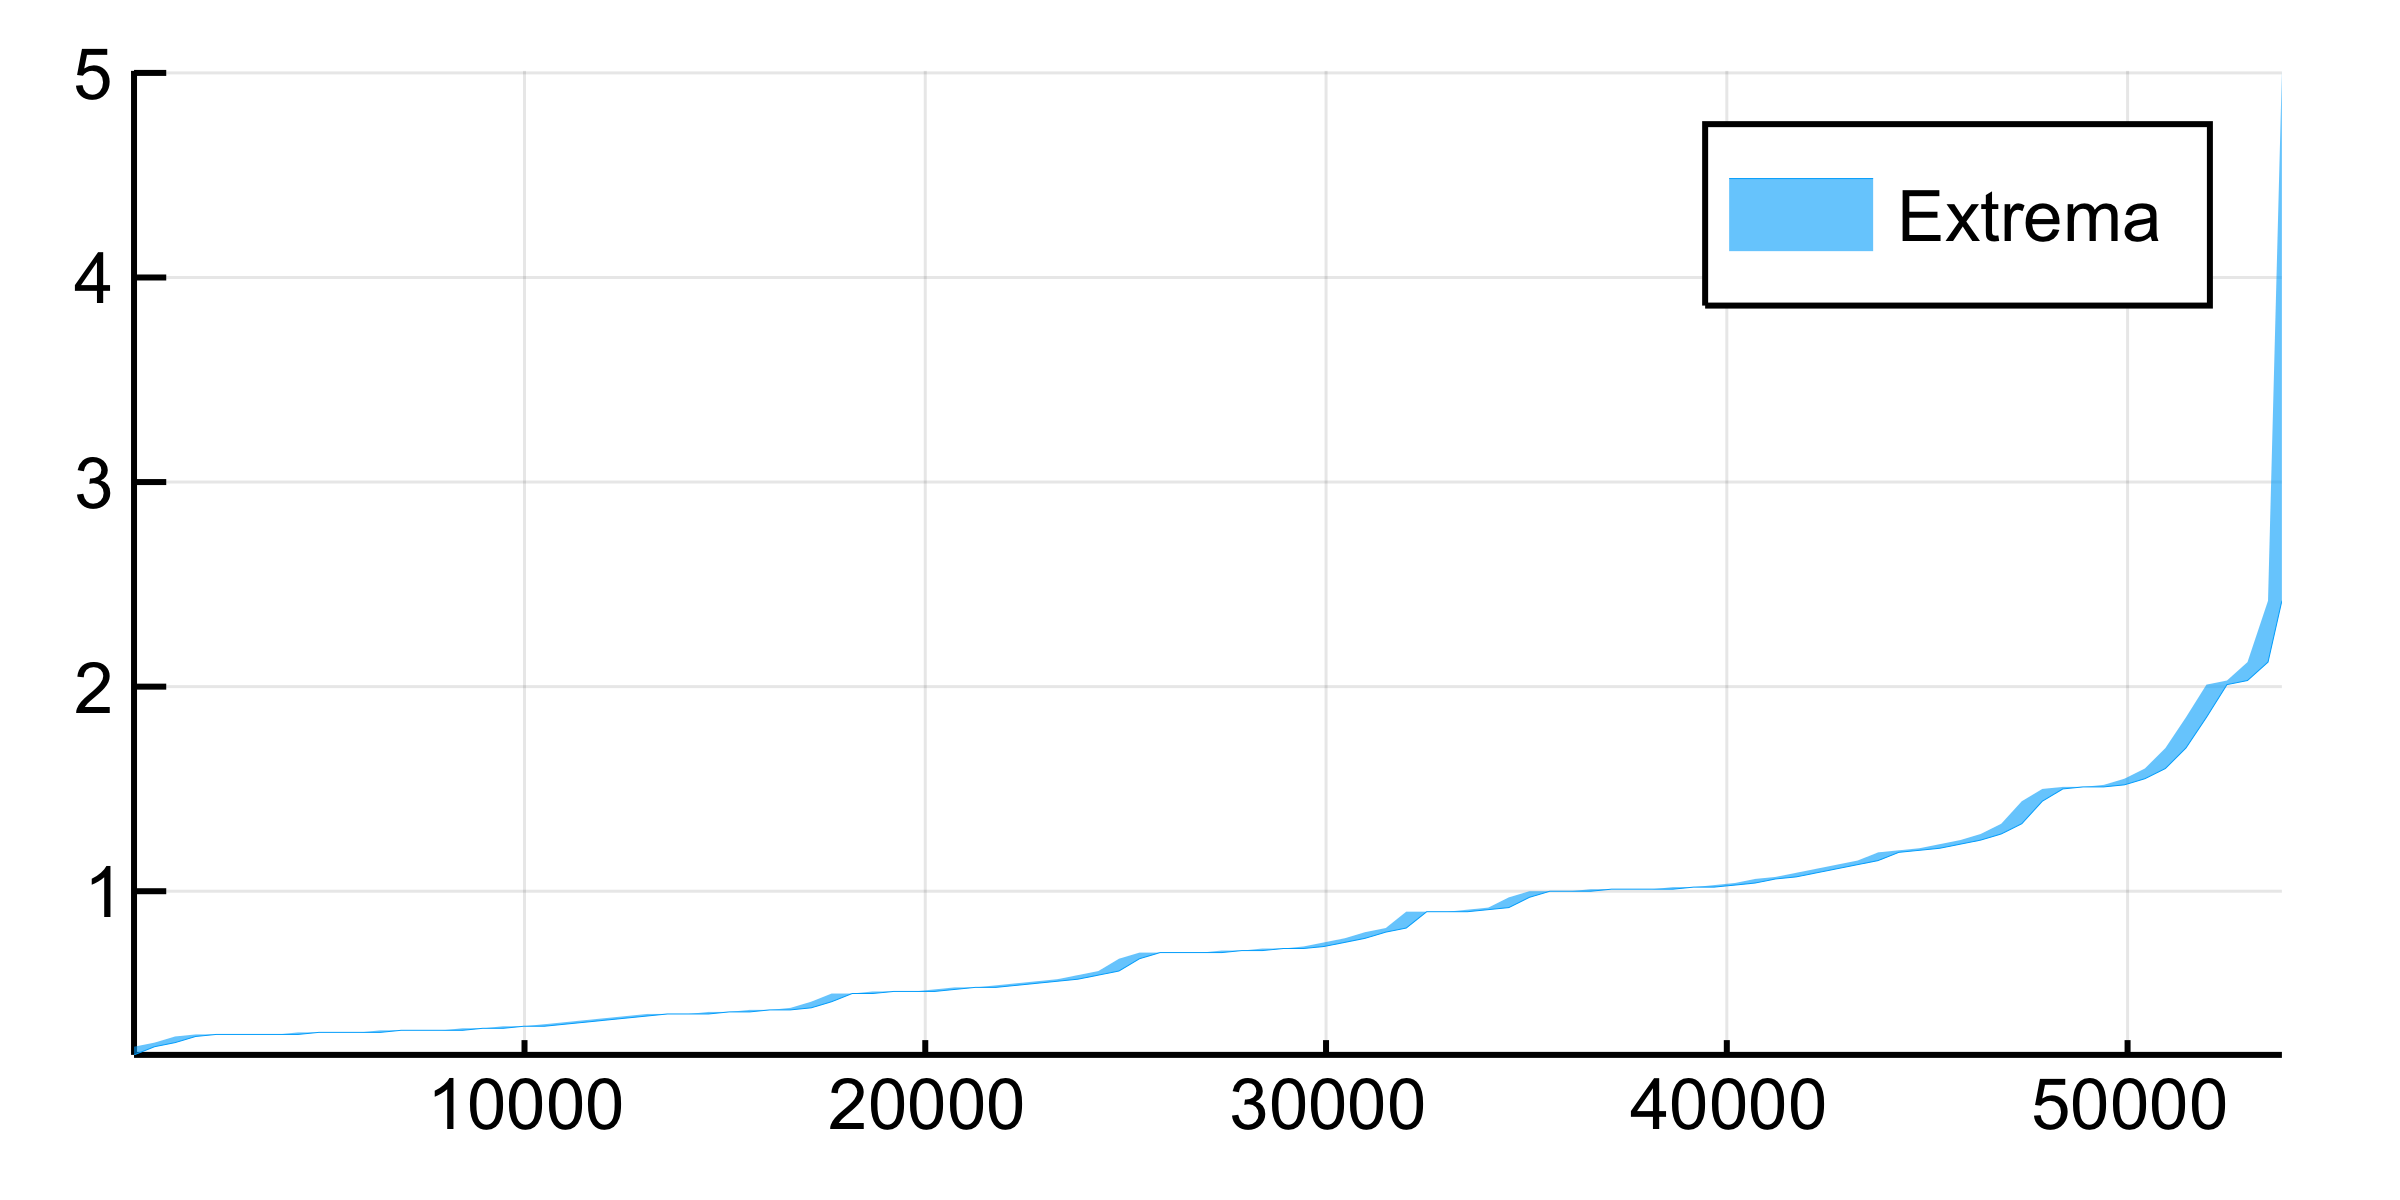

In [8]:
partitionplot(t, :carat)


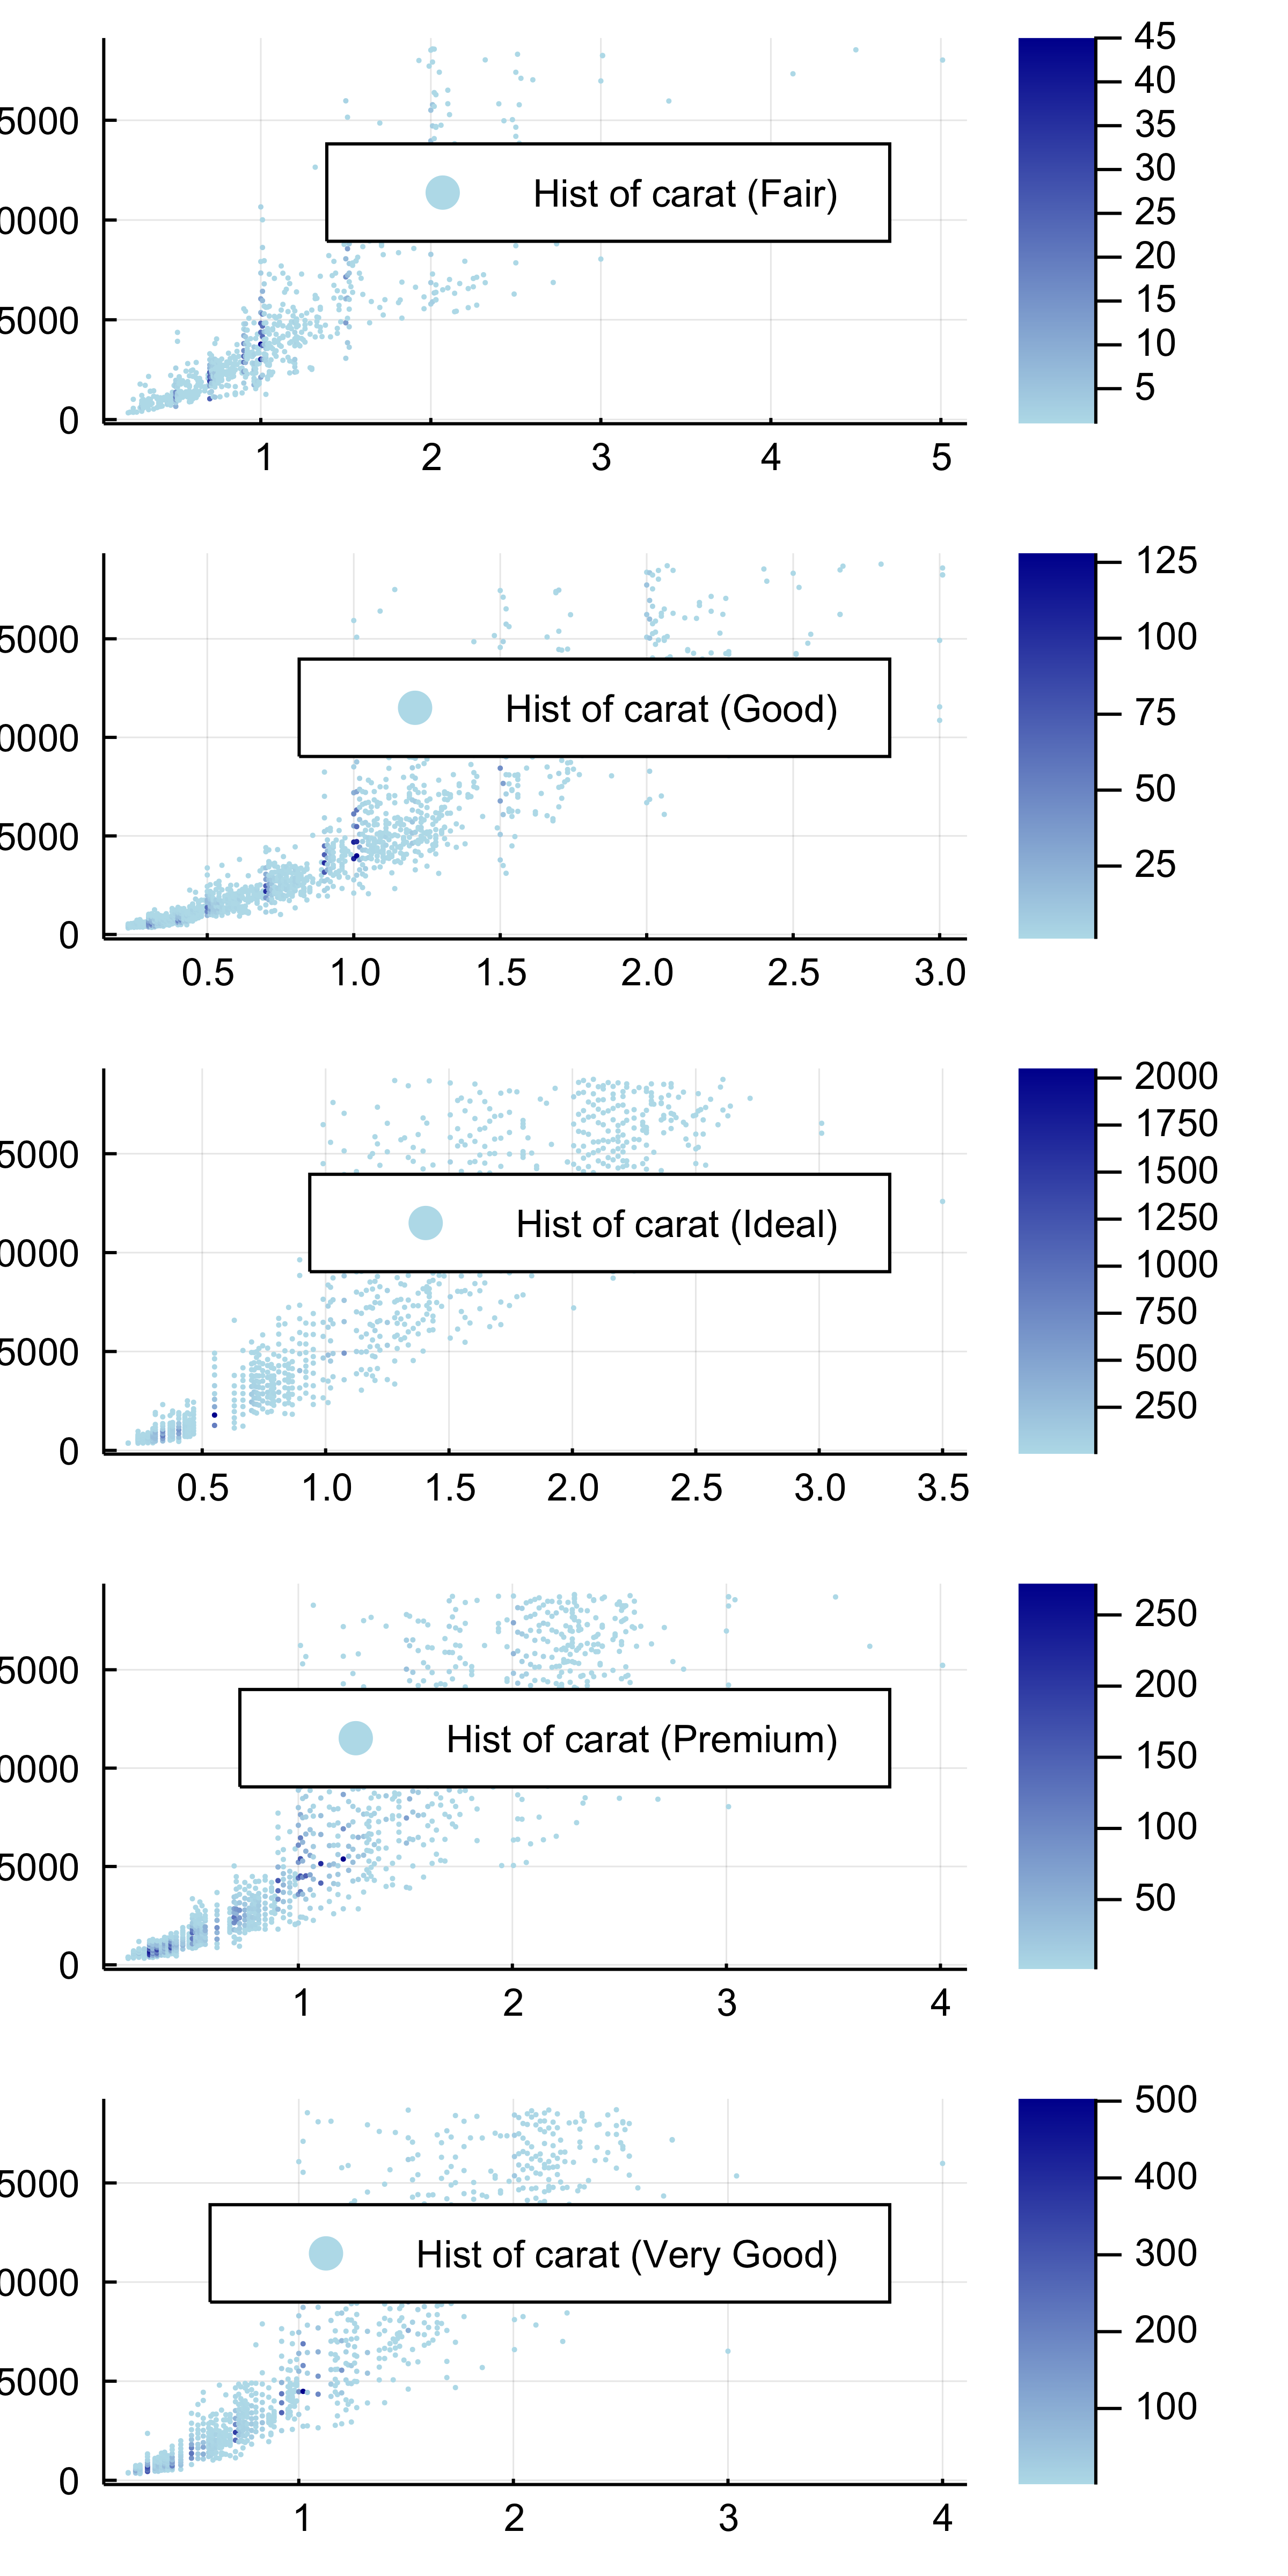

In [29]:
# Also accepts keyword args to Plots
partitionplot(t, :carat, :price; by = :cut, stat = Hist(10), 
    ms=1, layout = (5,1), size = (400,800))

# `reduce` and `groupreduce`

In [35]:
gr = groupreduce(Mean(), t, :cut; select = :carat)

gr[2]

(cut = "Good", Mean = ▦ Series{0}
│ EqualWeight | nobs=4906
└── Mean(0.849185))

In [11]:
o = IndexedPartition(String, Mean())

s = reduce(o, t; select = (:cut, :carat))

▦ Series{1}
│ EqualWeight | nobs=53940
└── IndexedPartition{String,Mean} (5 parts)

In [12]:
value(s)

([1.04614, 0.849185, 0.702837, 0.891955, 0.806381],)

# Plotting a `Series` plots its stats


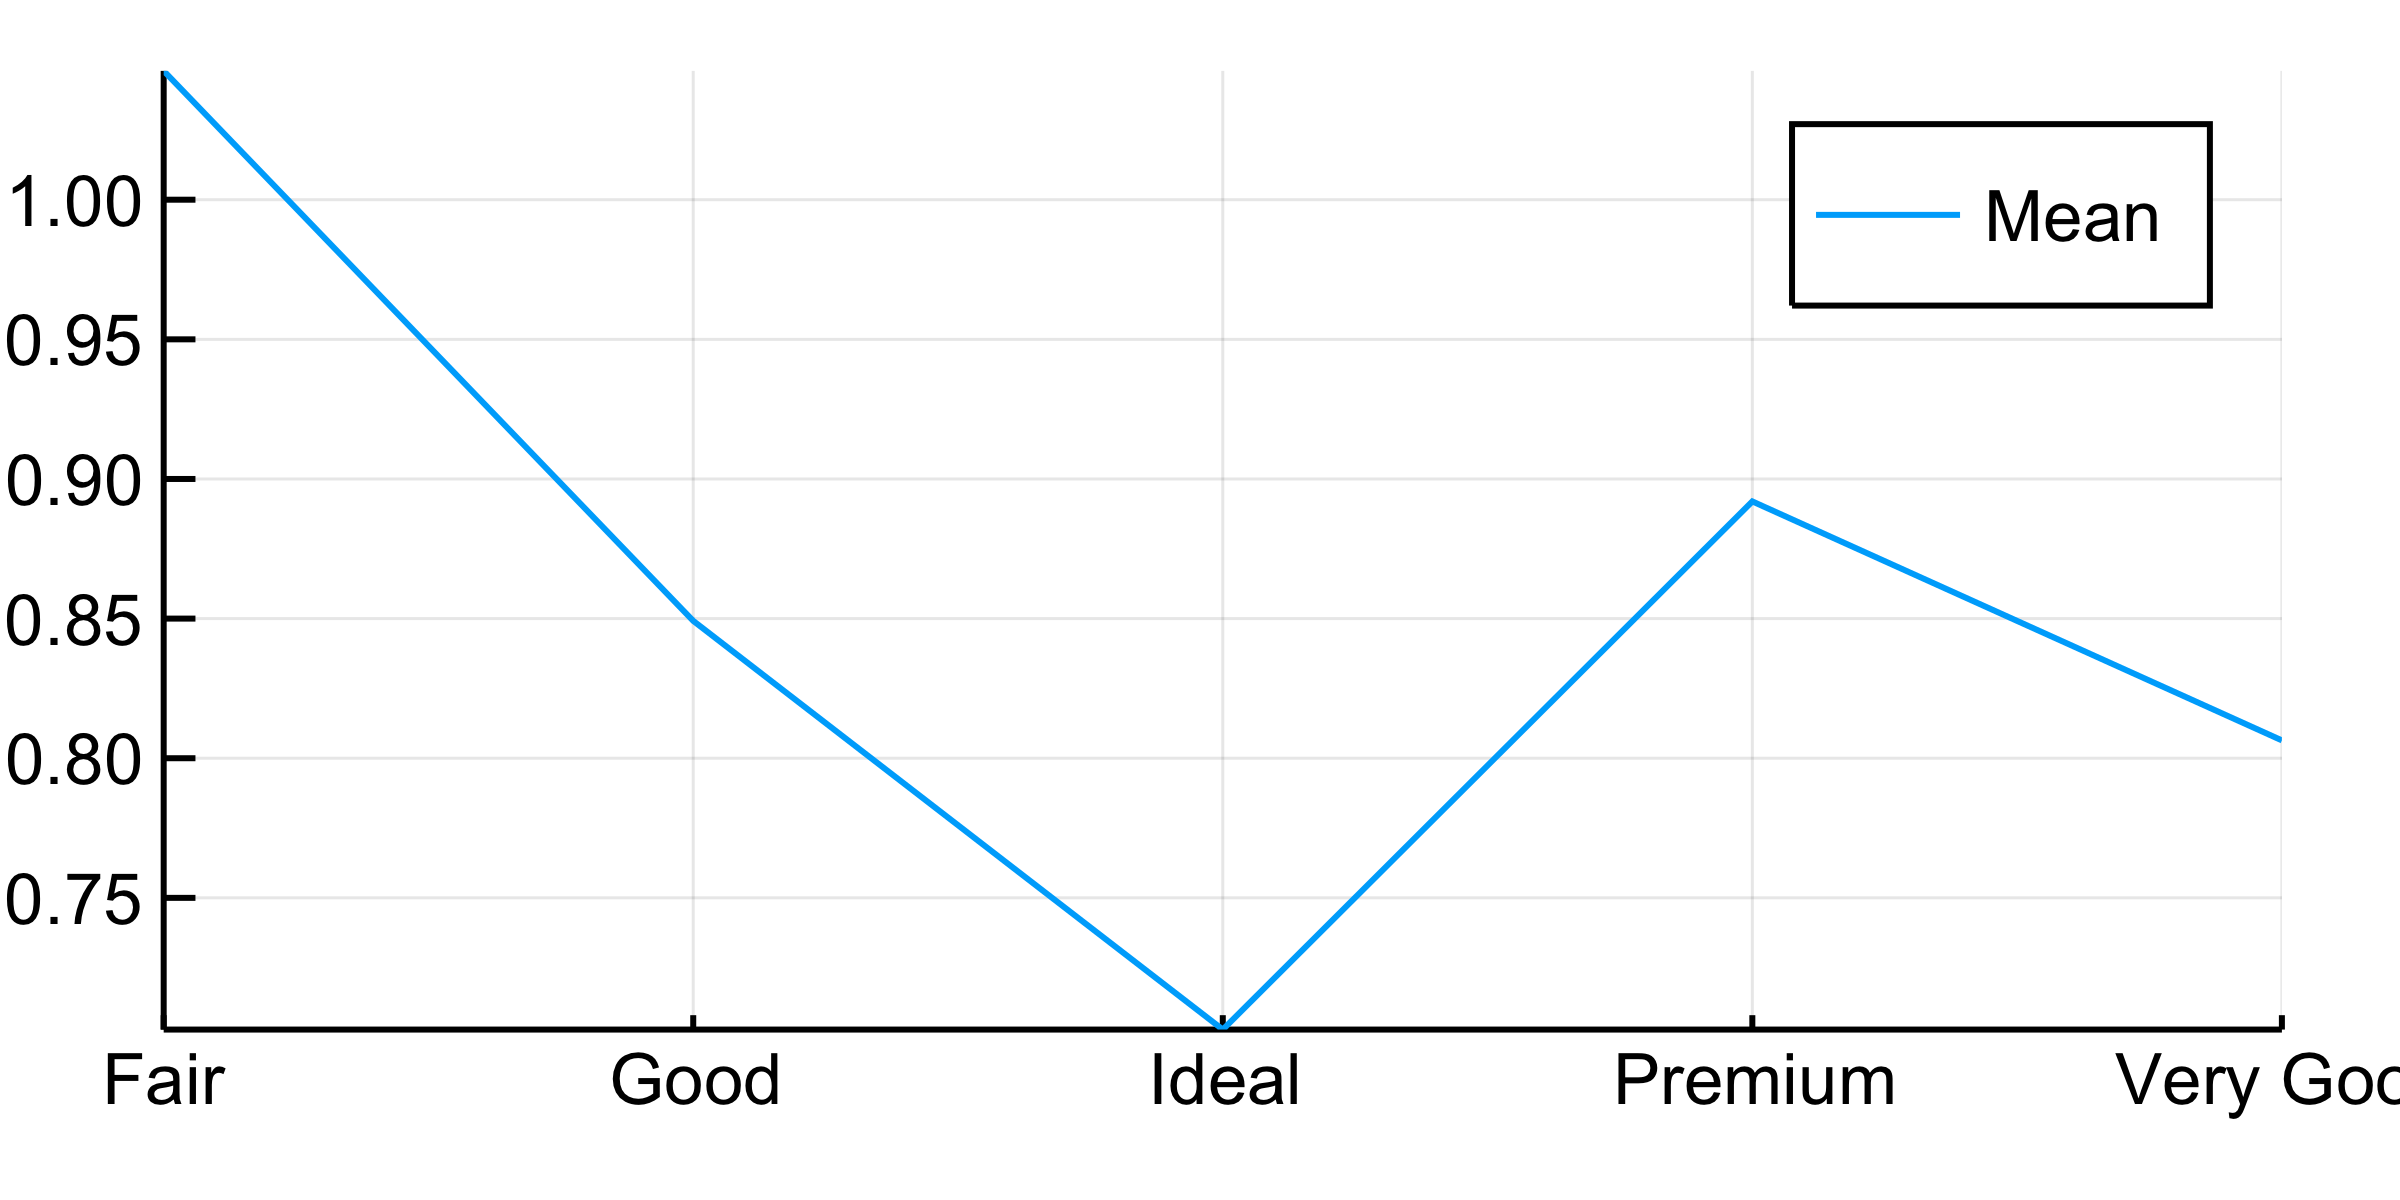

In [13]:
plot(s)

# Selection "size" must match the "size" of the `Series`


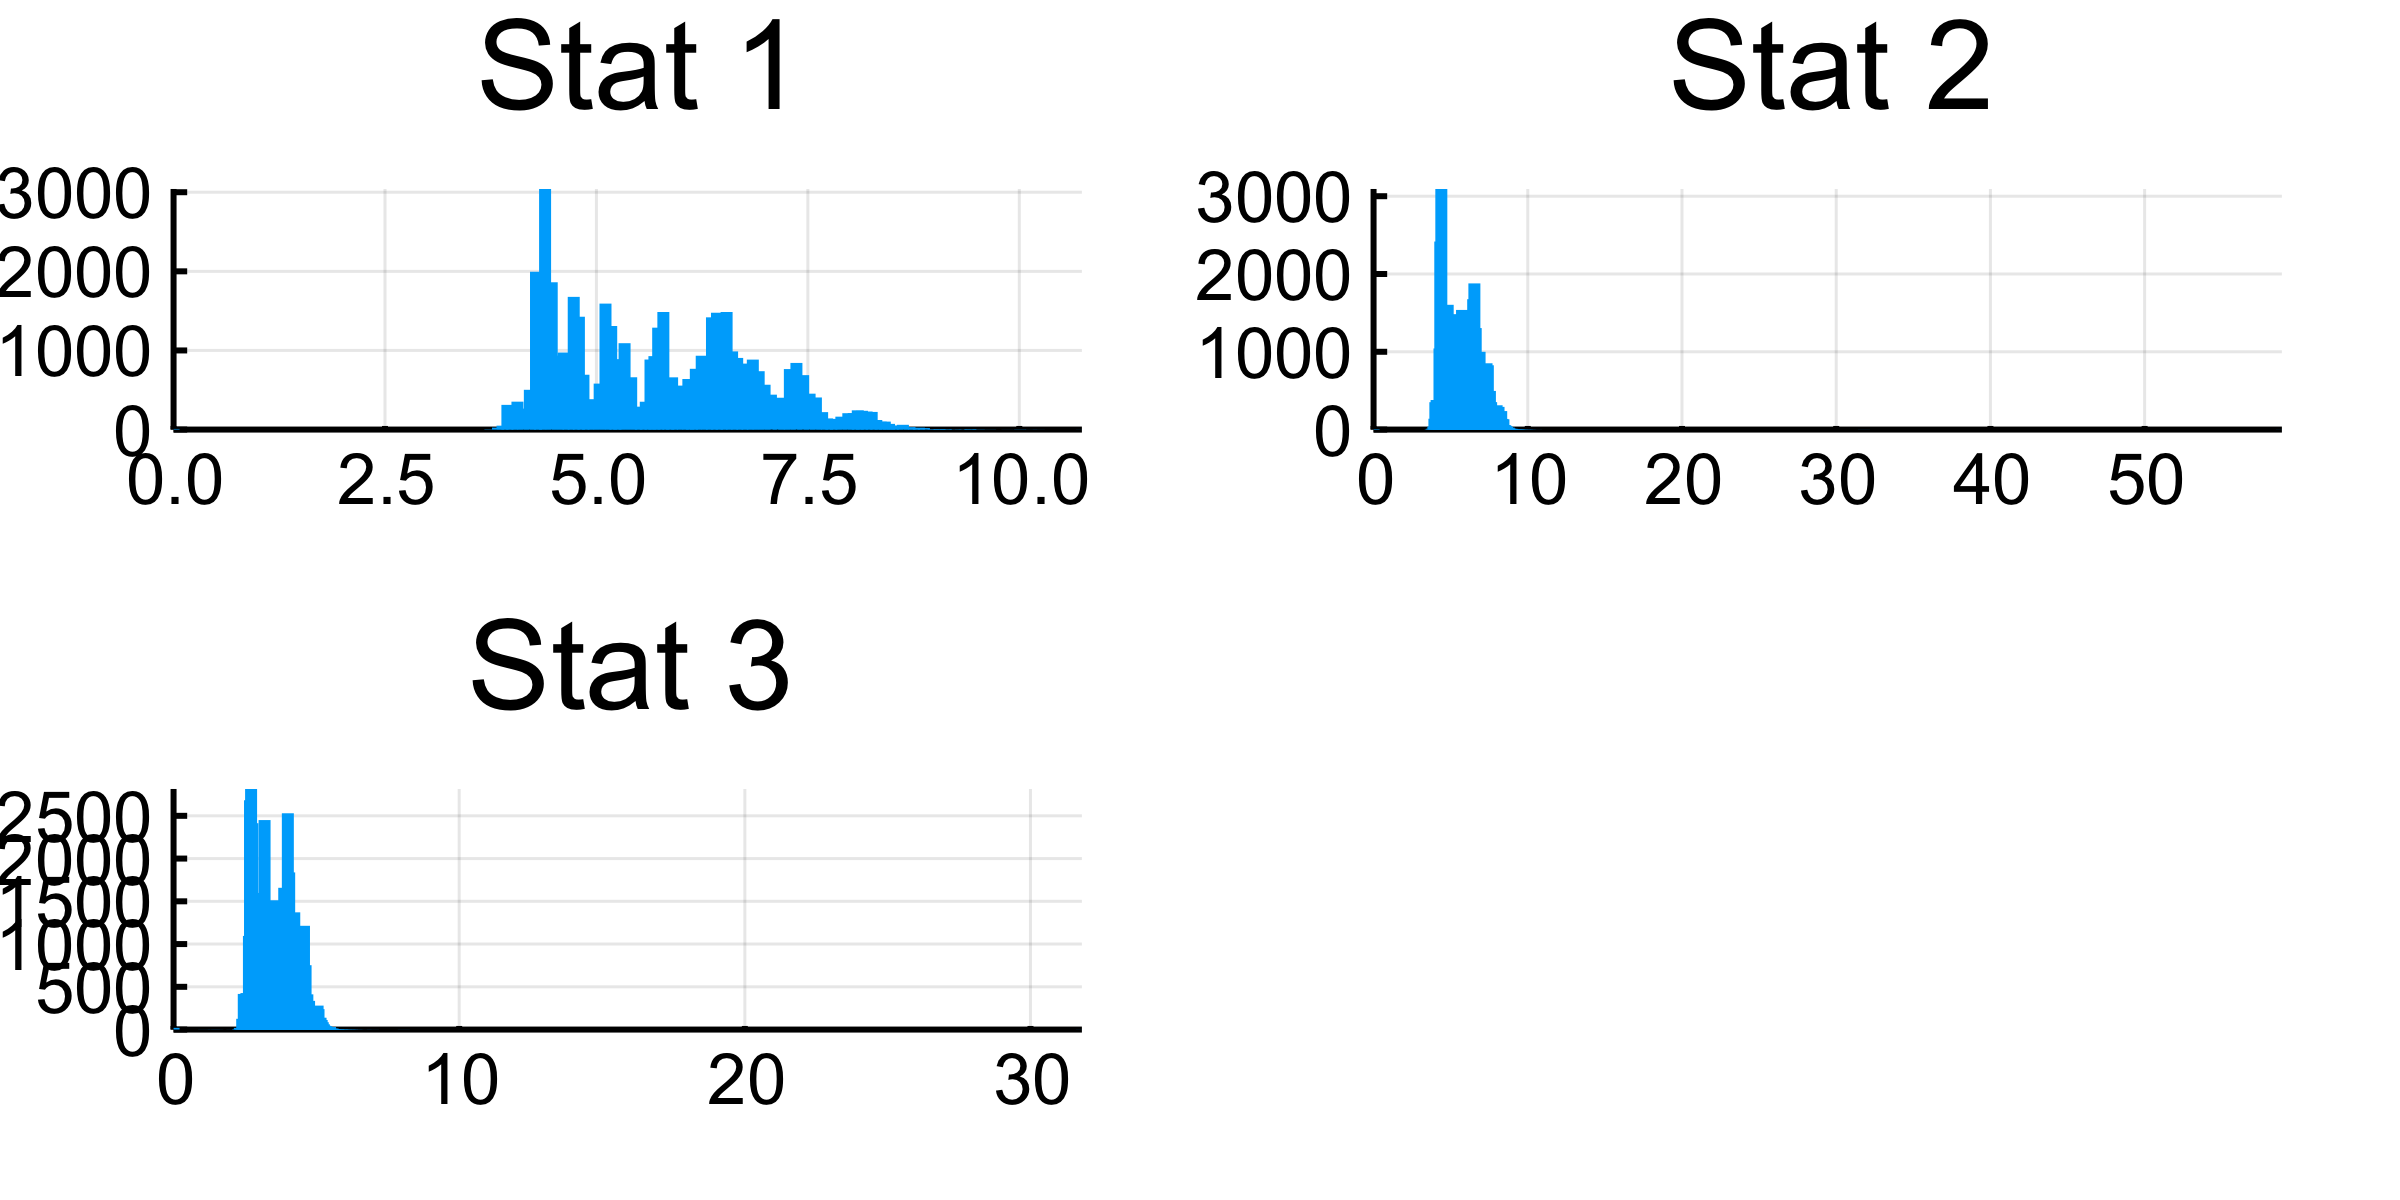

In [37]:
plot(reduce(3Hist(100), t; select = (:x, :y, :z)), legend=false, layout=3)


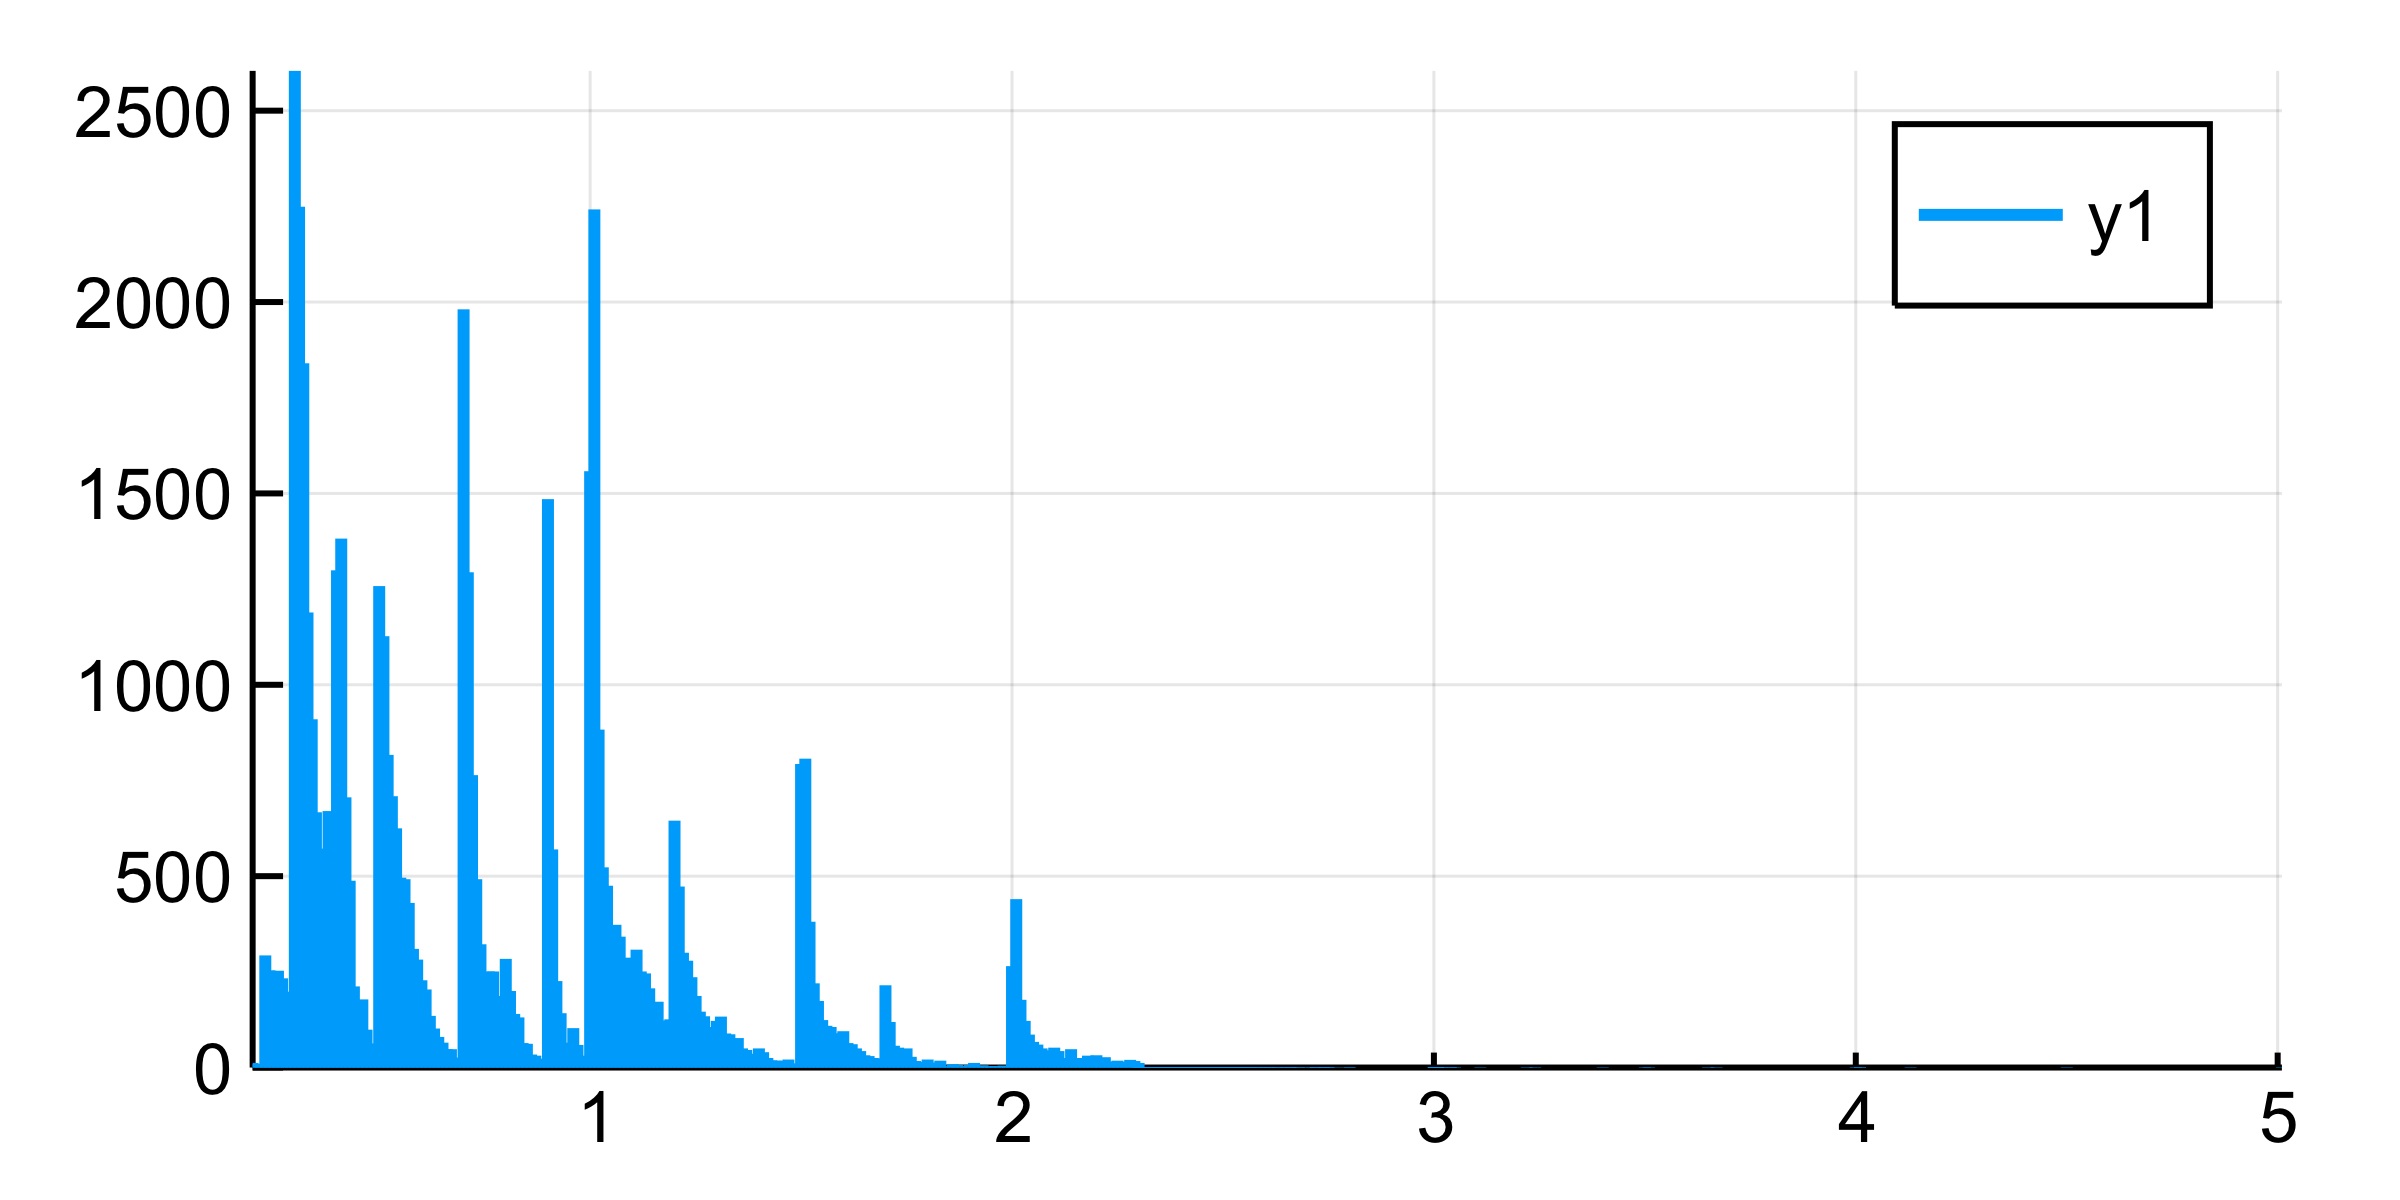

In [45]:
# try changing number of bins
plot(reduce(Hist(500), t; select = :carat))

# My favorite comparison of two categorical variables

### Mosaic Plot

- shows class probabilities of both variables


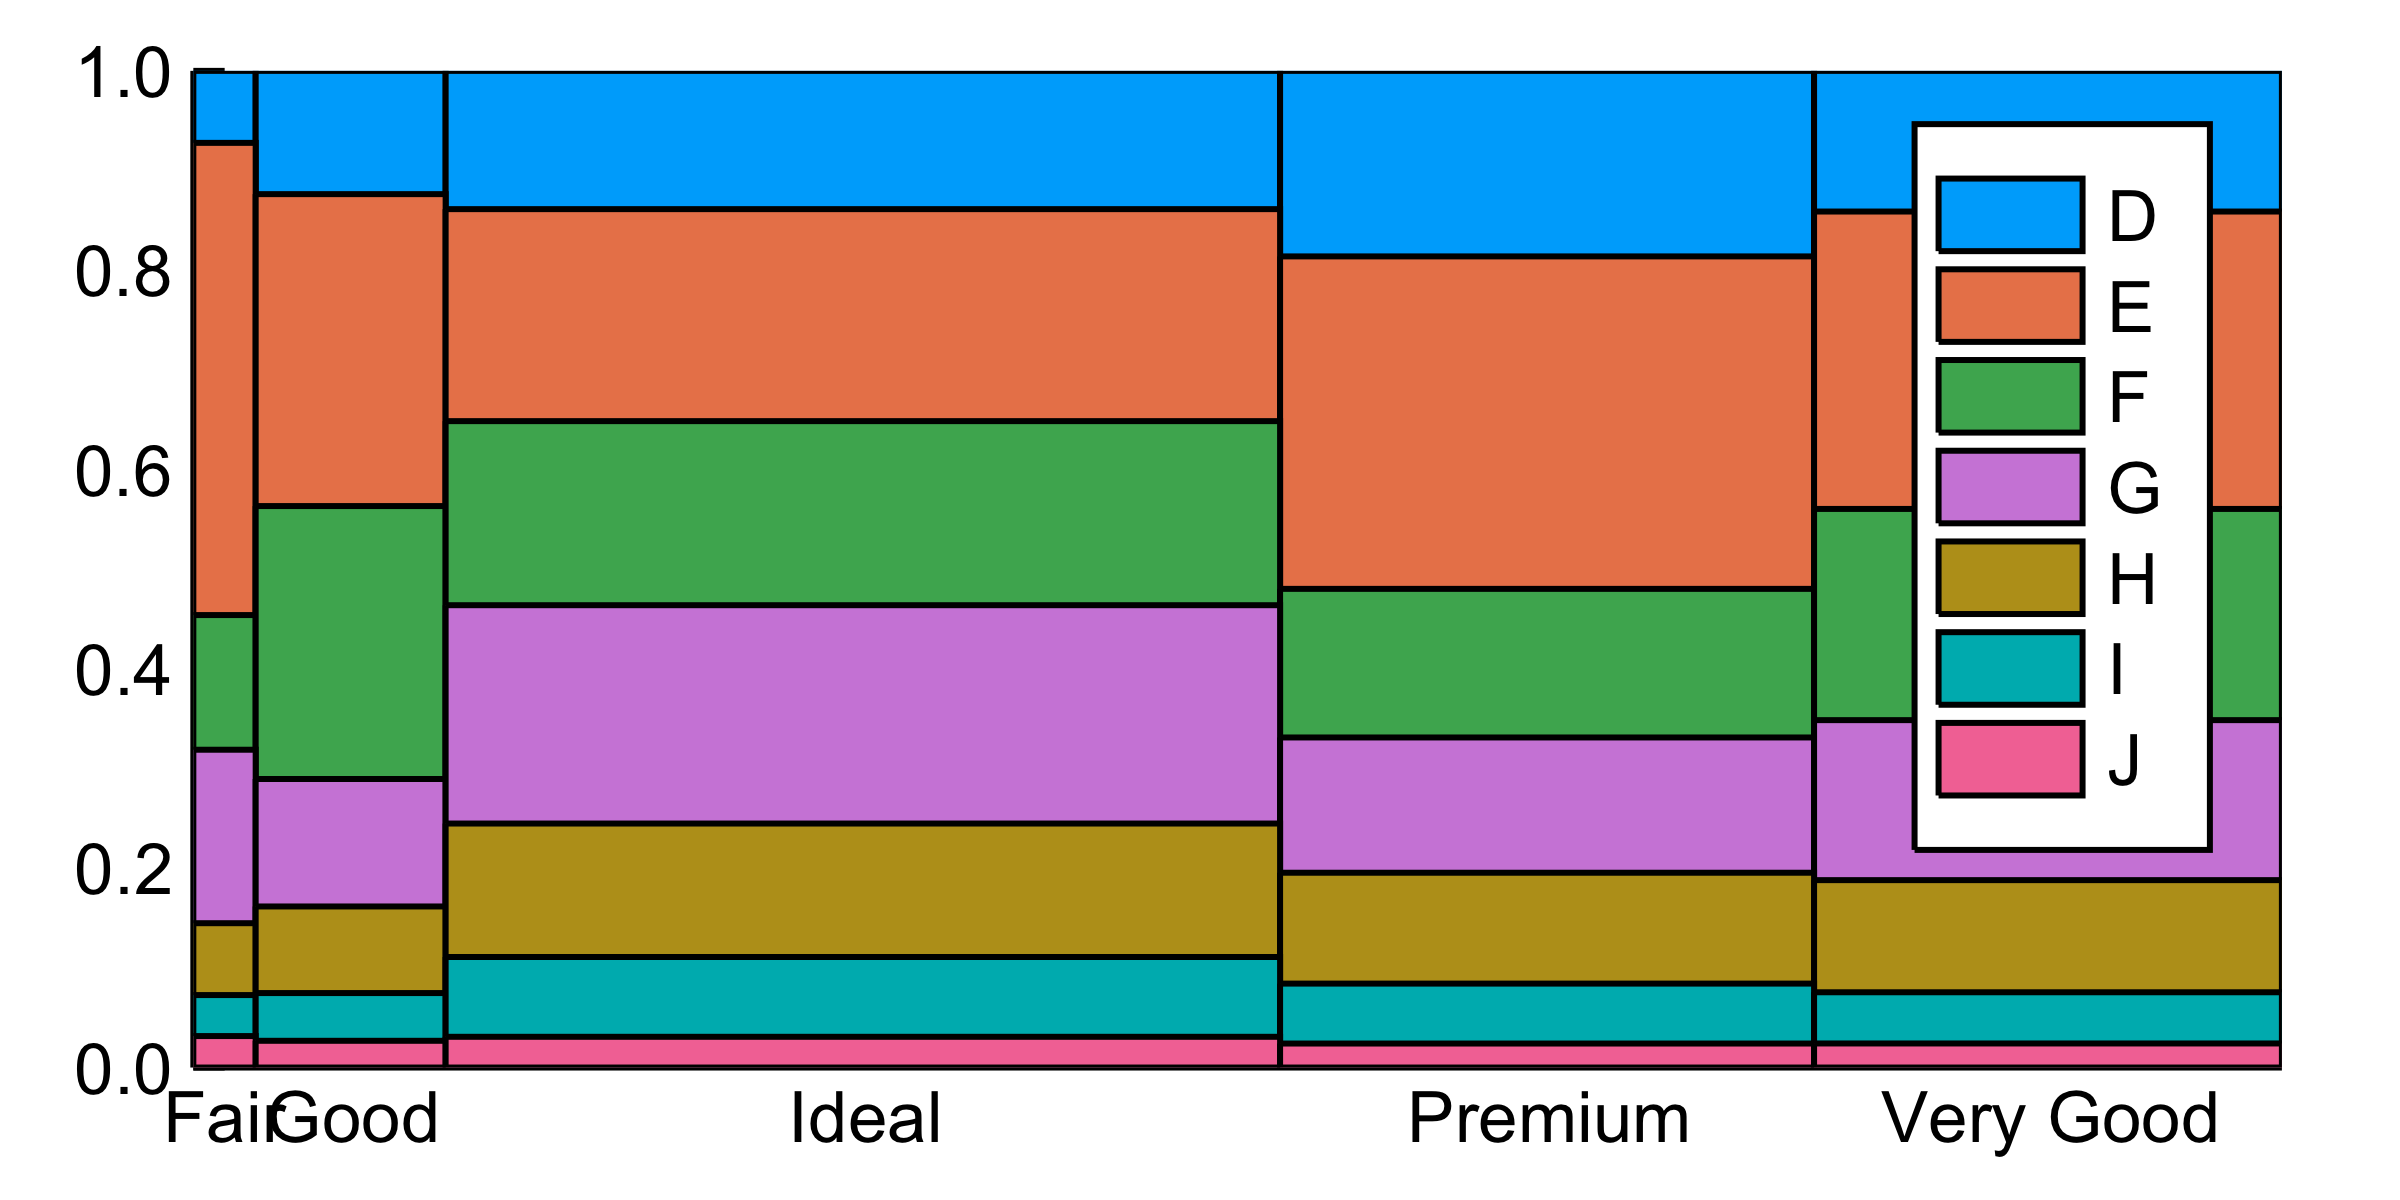

In [16]:
plot(reduce(Mosaic(String, String), t; select = (:cut, :color)))

# Statistical Models

In [46]:
x = (:carat,:depth,:table,:price,:x,:y,:z)

s = reduce(LinRegBuilder(7), t; select = x)

▦ Series{1}
│ EqualWeight | nobs=53940
└── LinRegBuilder of 7 variables

In [47]:
o = s.stats[1]

LinRegBuilder of 7 variables

In [59]:
coef(o; y=6, verbose=true)

INFO: Regress 6 on [1, 2, 3, 4, 5, 7] with bias


7-element Array{Float64,1}:
  0.0594417 
 -0.0206437 
 -0.00426392
  1.88748e-6
  0.819197  
  0.235414  
  1.67138   

#### Most models expect data as a tuple: `(x, y)`

In [66]:
reduce(LinReg(3), t; select = ((:x, :y, :z), :carat))

▦ Series{(1, 0)}
│ EqualWeight | nobs=53940
└── LinReg: β(0.0) = [0.1764 -0.0311904 0.00663214]

# Approximate Solutions to Statistical Learning

# `StatLearn`

You provide:
- Loss function you want to minimize
- Penalty function to prevent overfitting
- Algorithm; `SGD`, `ADAGRAD`, `MSPI`, ...

## Offline objective:
$$ \frac{1}{n}\sum_{i=1}^n f_i(\beta) + \sum_{j=1}^p \lambda_j g(\beta_j)$$

Losses:

- Linear regression: `L2DistLoss()`
- Logistic regression: `LogitMarginLoss()`
- Linear SVM: `L1HingeLoss()`
- Quantile regression: `QuantileLoss(q)`
- Huber regression: `HuberLoss(a)`
- Absolute loss regression: `L1DistLoss()`

Penalties:

- None: `NoPenalty()`
- Ridge: `L2Penalty()`
- Lasso: `L1Penalty()`
- Elastic net: `ElasticNetPenalty(a)`

## NOTE: cleaner syntax for the following is being worked on

In [67]:
# predictors with intercept/bias term
x = (:carat, :depth, :table, :price, :x, :y, :z) => r -> OnlineStats.BiasVec(r, 1.0)

# generate response: -1 or 1
y = :cut => x -> 2 * (x == "Ideal") - 1

o = StatLearn(8, LogitMarginLoss(), NoPenalty(), MSPI())

StatLearn{MSPI{Void},LogitMarginLoss,NoPenalty}
    > β       : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    > Loss    : LogitMarginLoss
    > Penalty : NoPenalty
    > Updater : MSPI

In [68]:
s = reduce(o, t; select = (x, y))

▦ Series{(1, 0)}
│ LearningRate(r = 0.6) | nobs=53940
└── StatLearn{MSPI{Void},LogitMarginLoss,NoPenalty}
    > β       : [1.39201e-5, 0.0041878, -0.0685309, 8.79047e-6, 0.000414872, 0.000594156, 0.000400795, 3.11706e-5]
    > Loss    : LogitMarginLoss
    > Penalty : NoPenalty
    > Updater : MSPI


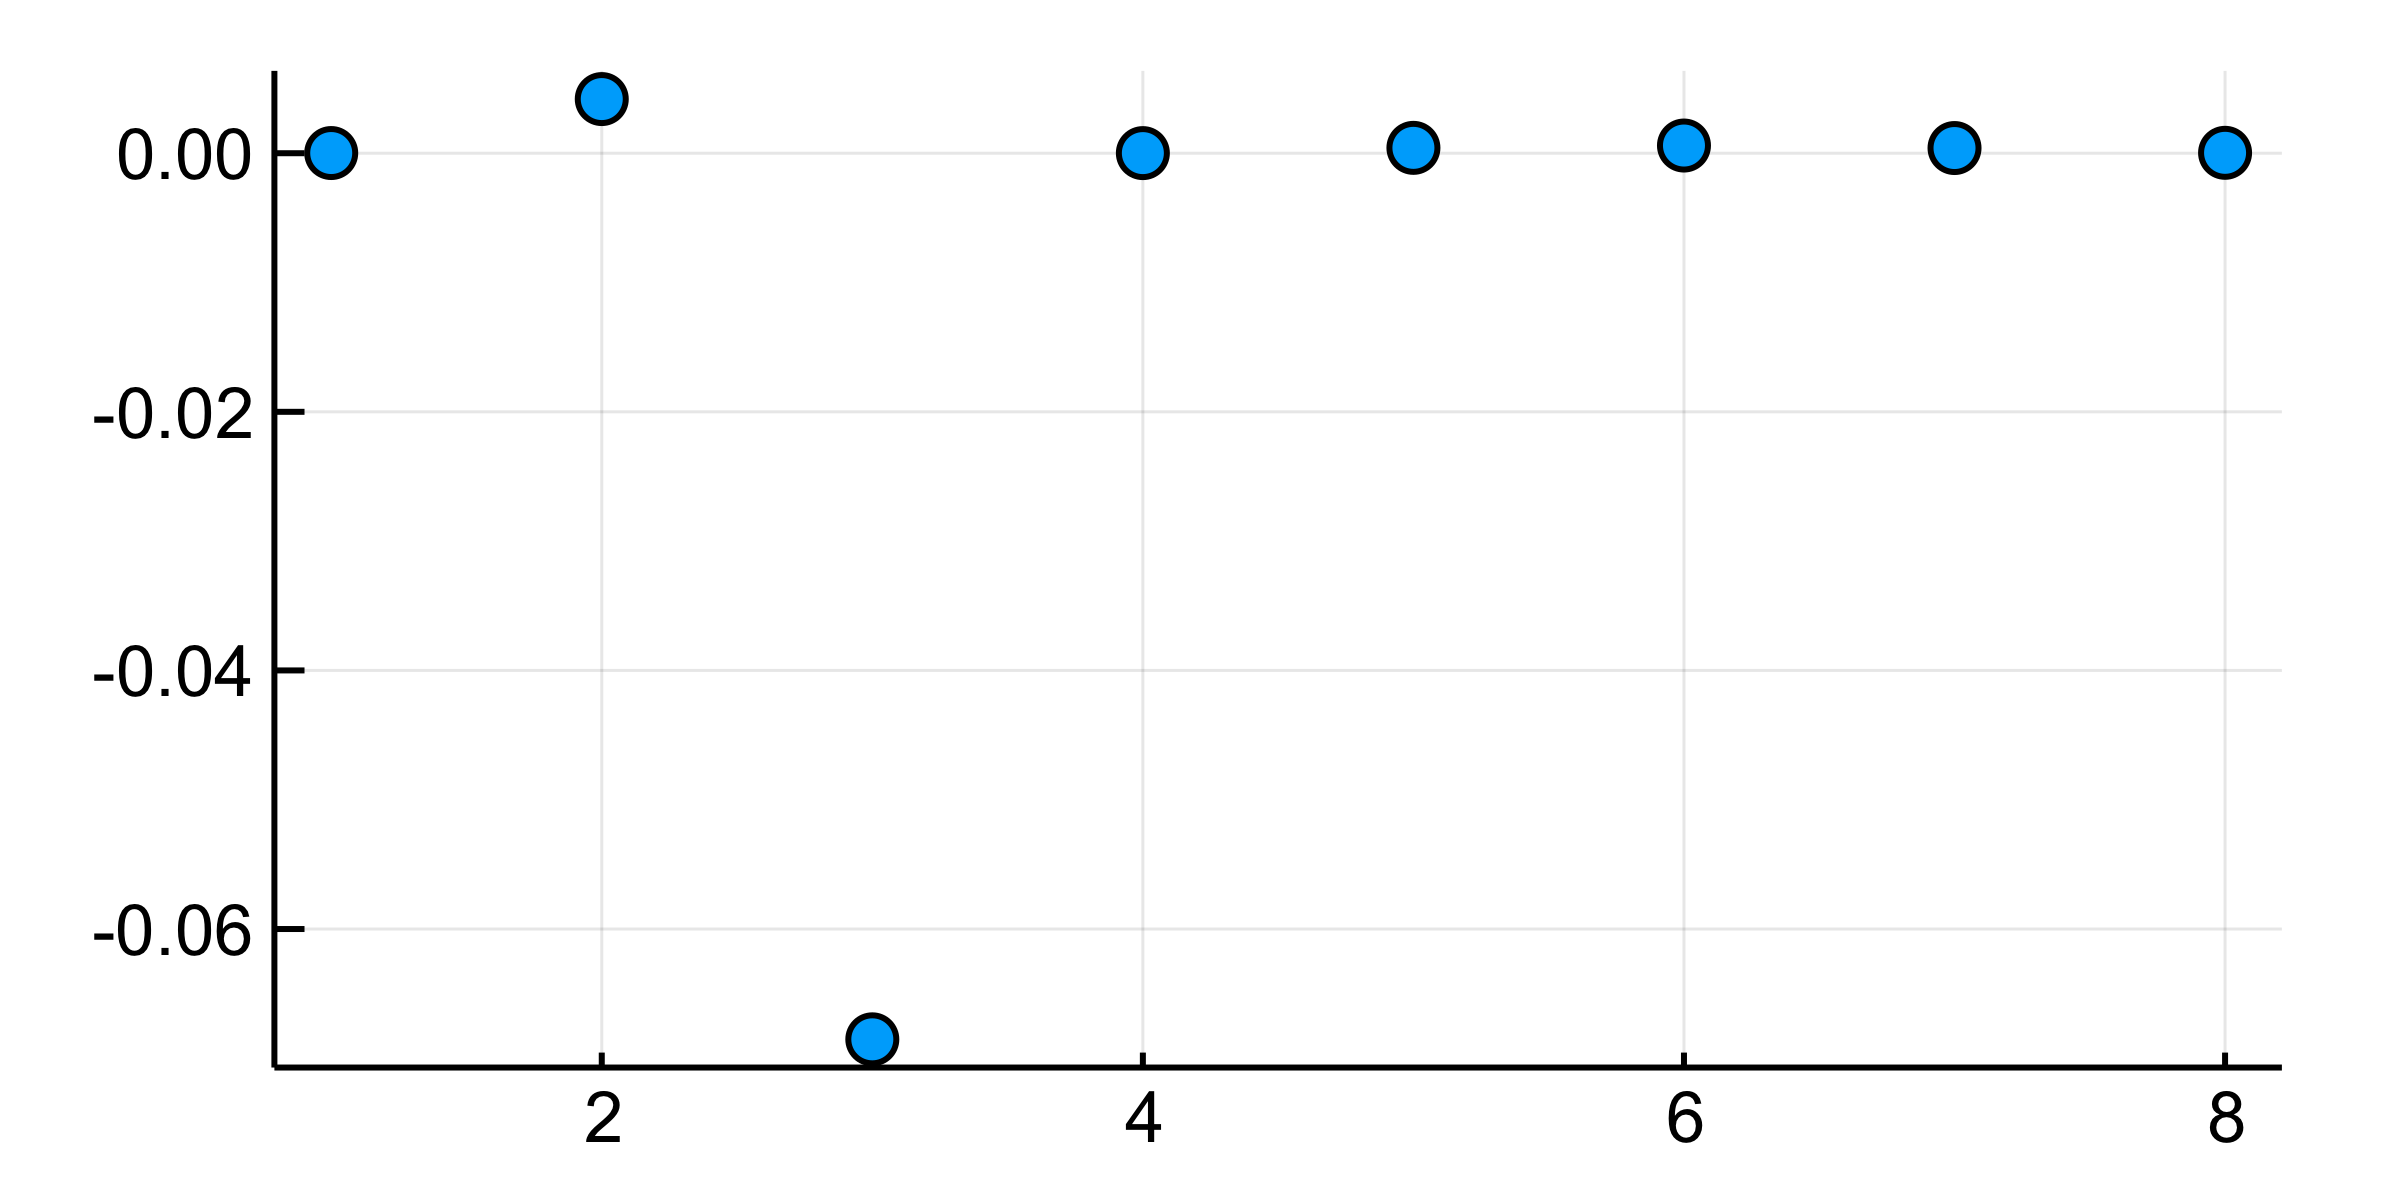

In [69]:
scatter(s, legend=false)

# Naive Bayes Classifier

- Classify a categorical variable $C_k$ from numerical predictors ($x_1,\ldots,x_p$)
- If predictor variables are independent (the naive part), then:

$$P(C_k| x_1,\ldots,x_p) \propto P(C_k)\prod_i P(x_i | C_k)$$

In [73]:
o = NBClassifier(7, String)

s = reduce(o, t; select = ((:carat,:depth,:table,:price,:x,:y,:z), :cut))

  0.216611 seconds (2.74 M allocations: 70.716 MiB, 13.62% gc time)


▦ Series{(1, 0)}
│ EqualWeight | nobs=53940
└── NBClassifier{String,MV{Hist{0,AdaptiveBins{Float64}}}}
    > Premium (0.2557)
    > Ideal (0.3995)
    > Very Good (0.224)
    > Fair (0.0298)
    > Good (0.091)


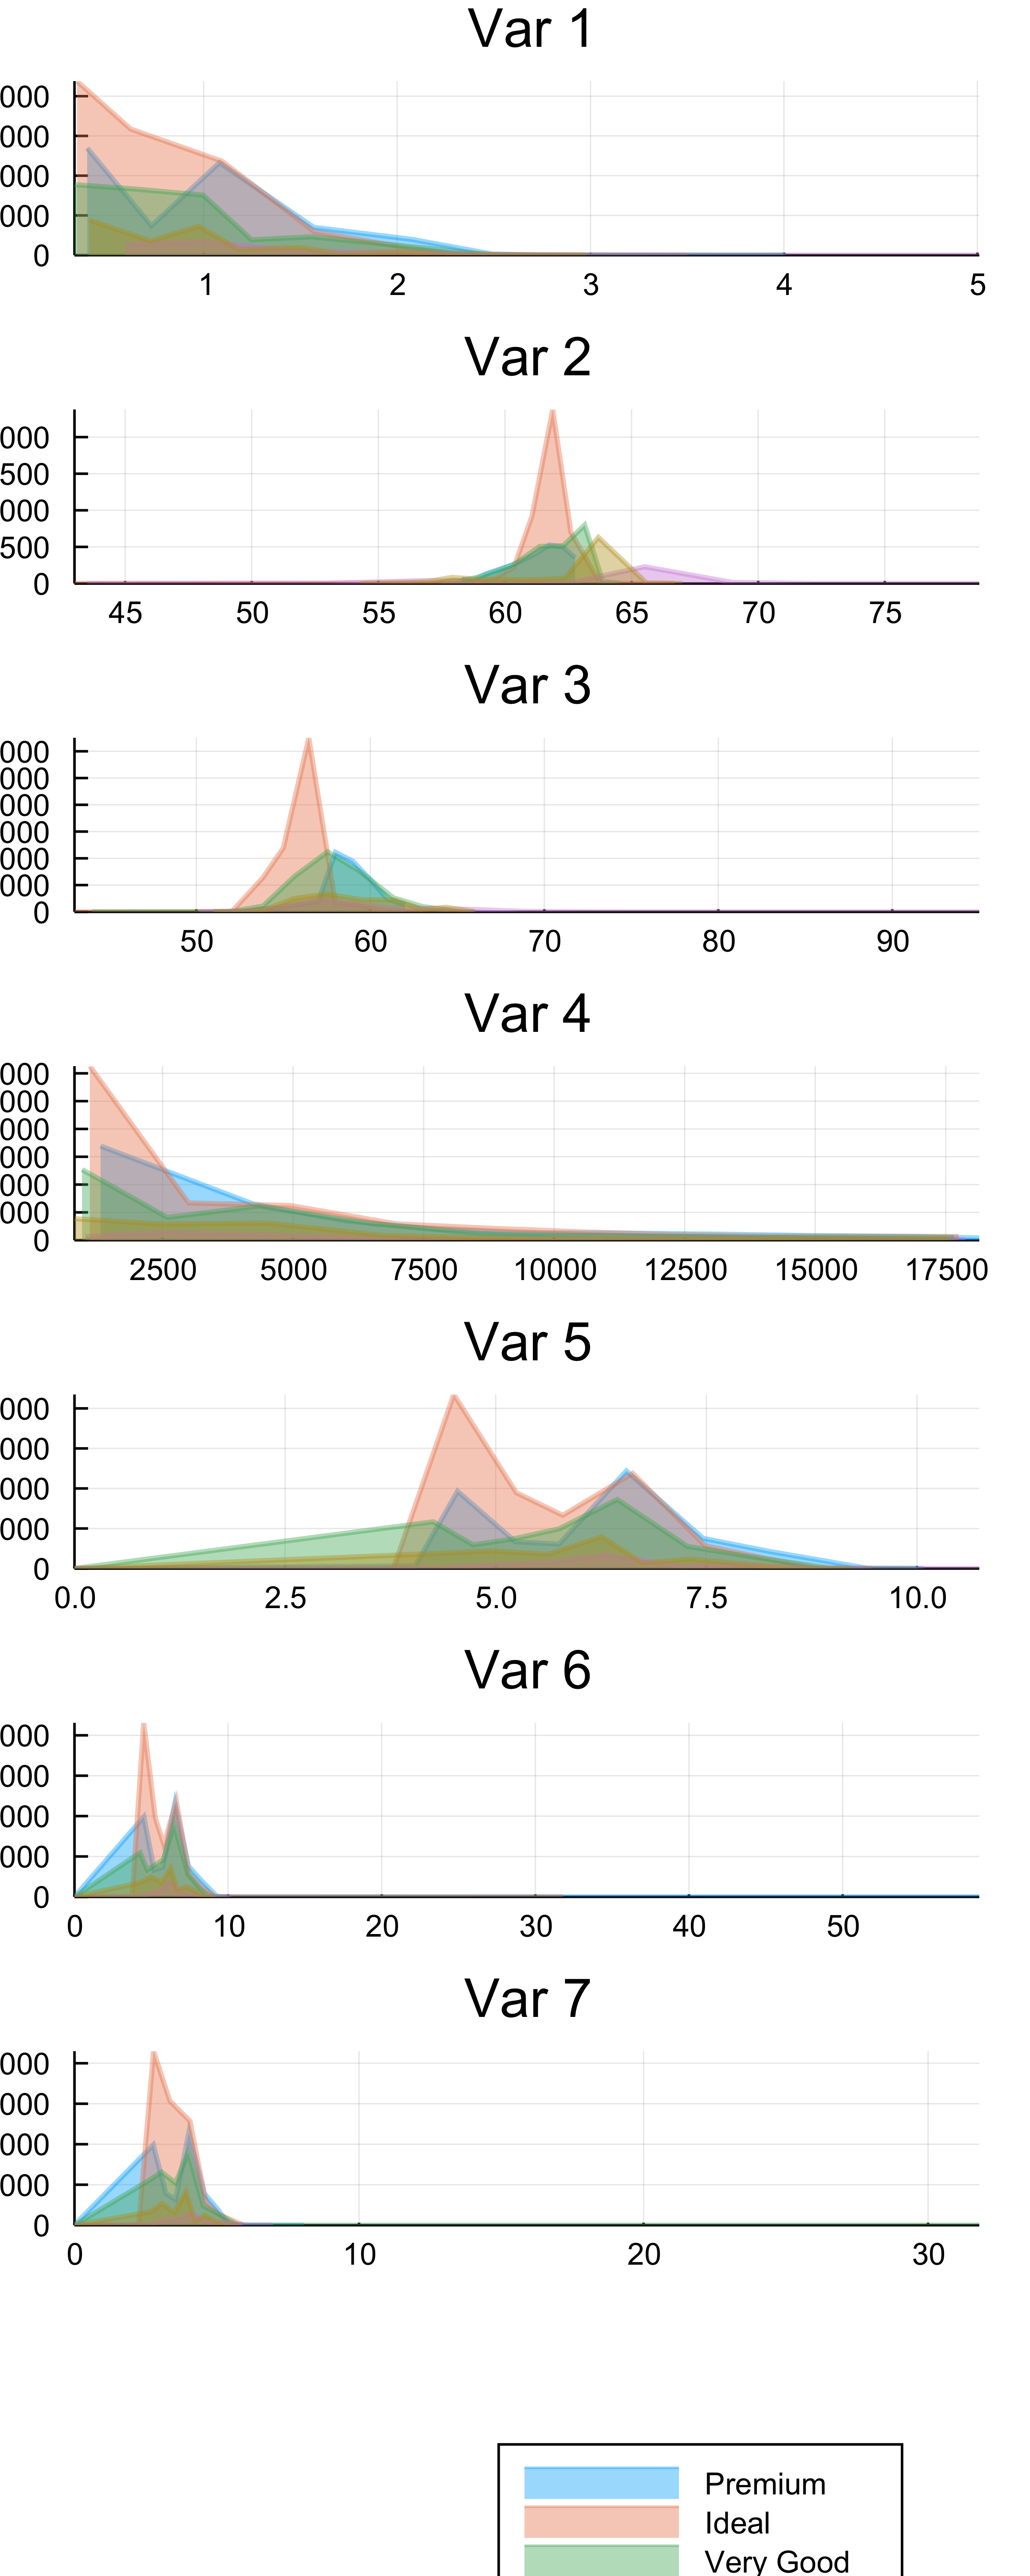

In [76]:
plot(s, layout = (8,1), size = (400,1000))